In [81]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os

In [95]:
root_directory = ".."
directory = "User-Revenue-Analytics/files/"  

I loaded three CSV files, each containing relevant project data: installs, in-app purchases (IAP), and  RV .

In [99]:
file_name = "installs.csv"
file_path = os.path.join(root_directory, directory, file_name)
df_installs = pd.read_csv(file_path,skipinitialspace=True)


file_name = "iap.csv"
file_path = os.path.join(root_directory, directory, file_name)
df_iap = pd.read_csv(file_path,skipinitialspace=True)

file_name = "rv.csv"
file_path = os.path.join(root_directory, directory, file_name)
df_rv = pd.read_csv(file_path,skipinitialspace=True)


I combined three DataFrames: df_installs with df_rv, df_installs with df_iap, and finally merged both results into df_merge.

In [84]:
df_inst_rv_merge = df_installs.merge(df_rv, how='left',on='user_id')
df_inst_iap_merge = df_installs.merge(df_iap, how='left',on='user_id')
df_merge = df_inst_rv_merge.merge(df_inst_iap_merge,how='outer',indicator=True)


These function  calculate the time difference in hours between two datetime objects

In [98]:
def passed_hours(install_time, revenue_time):
    time_difference = pd.Timestamp(revenue_time) - pd.Timestamp(install_time)
    return (time_difference.total_seconds() / 3600)



In [87]:
df_merge.insert(2,column = "first_24hours_revenue", value =0) 
df_merge.insert(3,column = "end_of_day_revenue", value =0)

df_merge['install_time'] = pd.to_datetime(df_merge['install_time'])
df_merge['date'] = pd.to_datetime(df_merge['date'])




In this section, I identify revenues generated at the end of the day and within 24 hours after downloading, then add them to the dataset.

In [ ]:
# this part may take 10-12 minutes
for index, row in tqdm(df_merge.iterrows(), total=len(df_merge)):
    install_time = row['install_time']
    date = row['date']
    time = row['time']
    purchase_value = row['purchase_value']
    ad_revenue = row['ad_revenue']
    
    if not pd.isna(time):
        if passed_hours(install_time, time) <= 24:
            df_merge.at[index, 'first_24hours_revenue'] = purchase_value
        if install_time.date() == pd.to_datetime(time).date():
            df_merge.at[index, 'end_of_day_revenue'] = purchase_value
            
    if not pd.isna(date):
        if install_time.date() == date.date():
            df_merge.at[index, 'end_of_day_revenue'] = ad_revenue
            df_merge.at[index, 'first_24hours_revenue'] = ad_revenue

In this section, I calculate various ARPU metrics based on the data:

In [101]:
total_purchase = df_merge['purchase_value'].sum()
unique_users = df_installs['user_id'].nunique()
total_ad_revenue = df_rv['ad_revenue'].sum()
total_1day_revenue = df_merge['first_24hours_revenue'].sum()
total_end_of_1day_revenue = df_merge['end_of_day_revenue'].sum()

In [102]:

iap_arpu = total_purchase / unique_users
rv_arpu = total_ad_revenue / unique_users
overall_arpu =(total_purchase +total_ad_revenue)/ unique_users
end_of_1day_arpu = total_end_of_1day_revenue / unique_users
day1_ARPU = total_1day_revenue / unique_users



In [103]:

print('iap_arpu :', iap_arpu)
print('rv_arpu :', rv_arpu)
print('overall_arpu :', overall_arpu )
print('first_24hours_revenue_ARPU :', day1_ARPU)
print('end_of_1day_arpu :', end_of_1day_arpu)

iap_arpu : 0.7937312154068215
rv_arpu : 0.45701563835608755
overall_arpu : 1.2507468537629092
first_24hours_revenue_ARPU : 0.3430026700855399
end_of_1day_arpu : 0.2765293628219536


I extract the years from the 'install_time' column in df_installs, then create a dictionary dates_dict to count the occurrences of each unique year.

In [59]:
years = [dt.split()[0].split('-')[0] for dt in (df_installs['install_time'])]
dates_dict = {}

unique_dates= pd.Series(years).unique().tolist()
for i in unique_dates:
    dates_dict[i] = years.count(i)


2024
{'2024': 1431466, '1970': 2, '2021': 3, '2023': 19, '2022': 4, '2020': 1, '2001': 2, '2017': 3, '2011': 1, '2007': 2, '2016': 1, '2015': 1, '2032': 1, '2025': 3, '2031': 1, '2010': 1, '2004': 1}



I sort and extract the first 13 items from the dates_dict dictionary, calculate the total count of installs for these years, and plot a bar graph showing the install count per year using matplotlib.

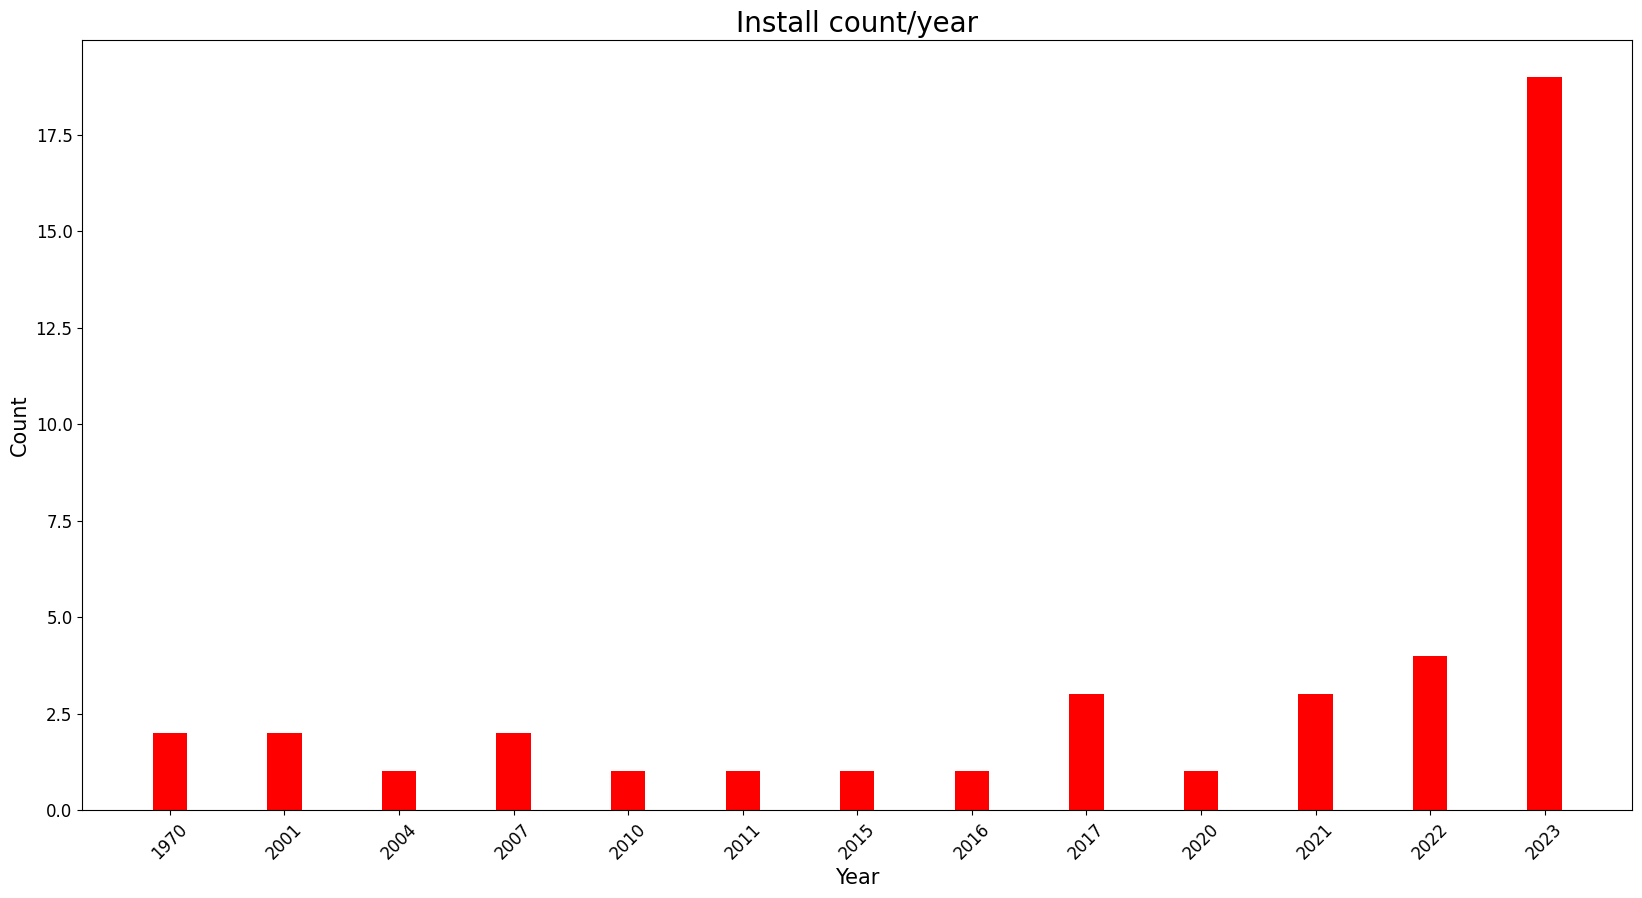

In [100]:


sorted_data = sorted(dates_dict.items())
sum_count = 0
x = [item[0] for item in sorted_data[:13]]
y = [item[1] for item in sorted_data[:13]]
for item in sorted_data[:13]:
    sum_count +=item[1]

plt.figure(figsize=(20, 10))
plt.bar(x, y, color='red', width=0.3)

plt.title('Install count/year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

